In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
import micrograd_pp as mpp
import numpy as np
from tqdm.notebook import trange

mpl.style.use("fivethirtyeight")
plt.rcParams["lines.linewidth"] = 2

In [2]:
mnist = mpp.datasets.load_mnist(normalize=True)
train_images, train_labels, test_images, test_labels = mnist

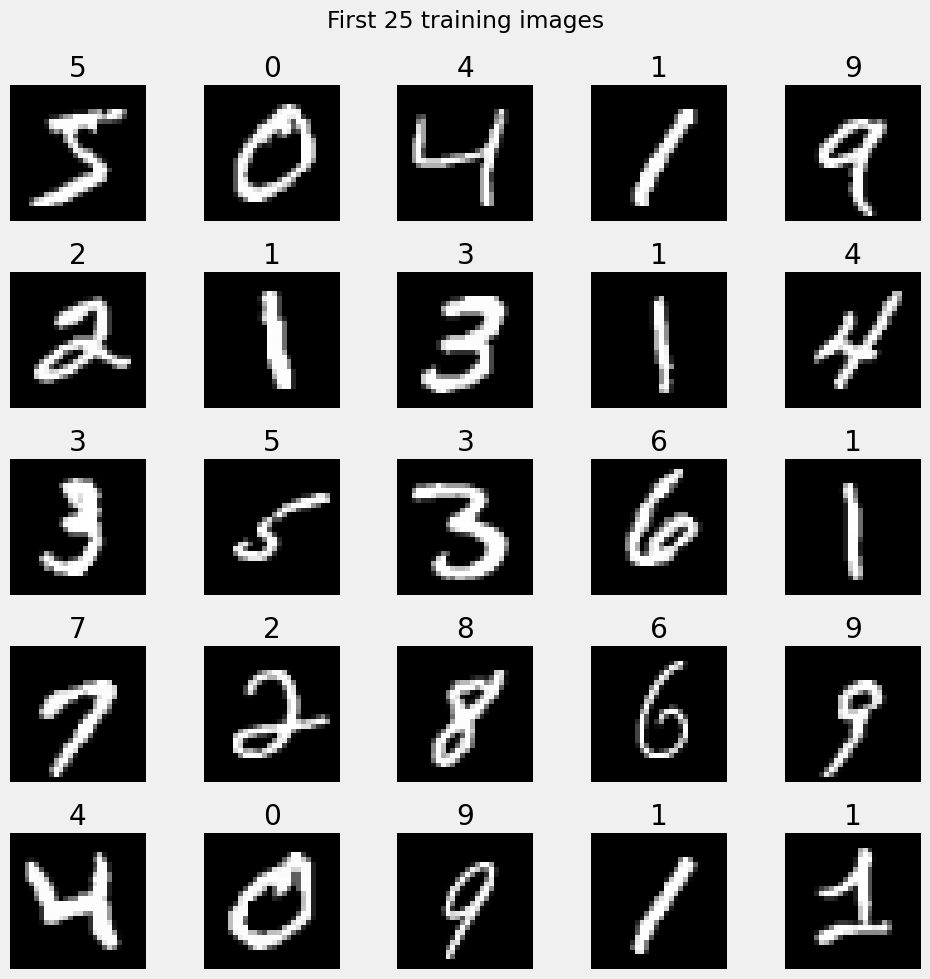

In [3]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i], cmap="gray")
    plt.title(train_labels[i])
    plt.axis("off")
plt.suptitle("First 25 training images");
plt.tight_layout()

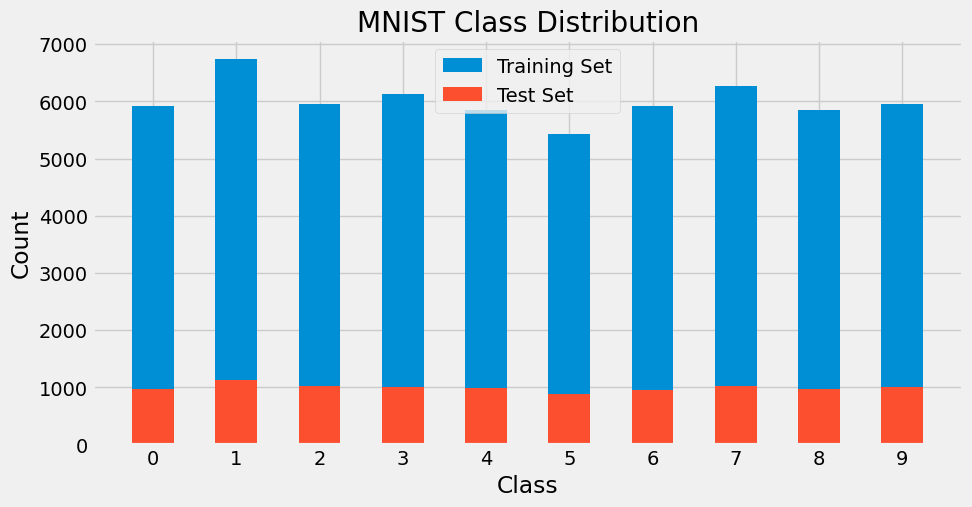

In [4]:
plt.figure(figsize=(10, 5))
plt.hist(train_labels, align="left", bins=range(11), rwidth=0.5, label="Training Set")
plt.hist(test_labels, align="left", bins=range(11), rwidth=0.5, label="Test Set")
plt.xticks(range(10))
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("MNIST Class Distribution")
plt.legend();

In [5]:
batch_sz = 64
n_epochs = 20

# Flatten images
train_images_ = train_images.reshape(-1, 28 * 28)
test_images_ = test_images.reshape(-1, 28 * 28)

# Drop extra training examples
trim = train_images_.shape[0] % batch_sz
train_images_ = train_images_[: train_images_.shape[0] - trim]

# Shuffle
indices = np.random.permutation(train_images_.shape[0])
train_images_ = train_images_[indices]
train_labels_ = train_labels[indices]

# Make batches
n_batches = train_images_.shape[0] // batch_sz
train_images_ = np.split(train_images_, n_batches)
train_labels_ = np.split(train_labels_, n_batches)

# Optimizer
opt = mpp.SGD(lr=0.01)

# Feedforward neural network
model = mpp.Sequential(
    mpp.Linear(28 * 28, 128),
    mpp.ReLU(),
    mpp.Linear(128, 10),
)


def cross_entropy_loss(input_: mpp.Expr, target: mpp.Expr) -> mpp.Expr:
    n, _ = input_.shape
    input_max = input_.max(dim=1, keepdim=True)
    delta = input_ - input_max
    log_sum_exp = delta.exp().sum(dim=1).log().squeeze()
    return (log_sum_exp - delta[np.arange(n), target]).sum() / n

# Train
accuracies = []
for epoch in trange(n_epochs):
    for batch_index in np.random.permutation(np.arange(n_batches)):
        x = mpp.Constant(train_images_[batch_index])
        y = train_labels_[batch_index]
        loss = cross_entropy_loss(model(x), y)
        loss.backward(opt=opt)
        opt.step()
    test_x = mpp.Constant(test_images_)
    test_fx = model(test_x)
    pred_labels = np.argmax(test_fx.value, axis=1)
    accuracy = (pred_labels == test_labels).mean().item()
    accuracies.append(accuracy)

  0%|          | 0/20 [00:00<?, ?it/s]

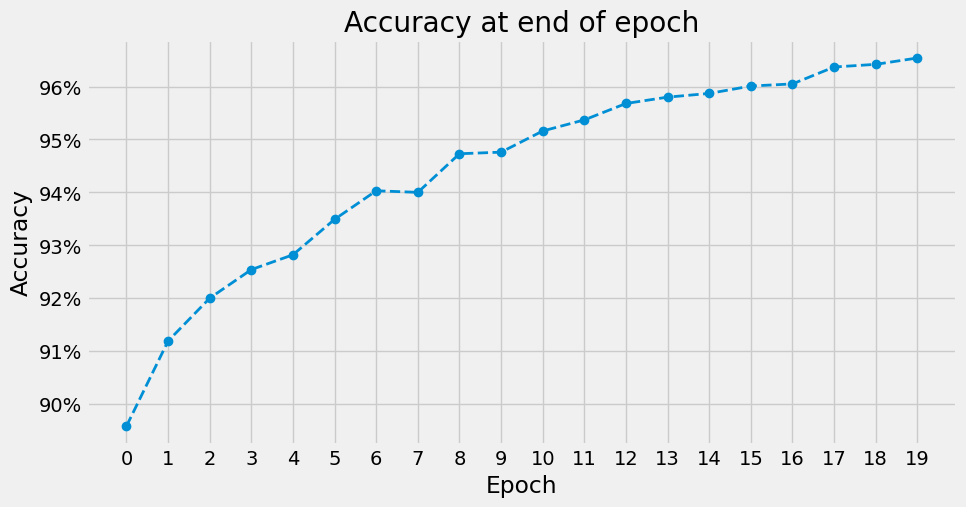

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies) * 100, "--o")
plt.xticks(range(len(accuracies)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy at end of epoch")
plt.gca().yaxis.set_major_formatter("{x:.0f}%")

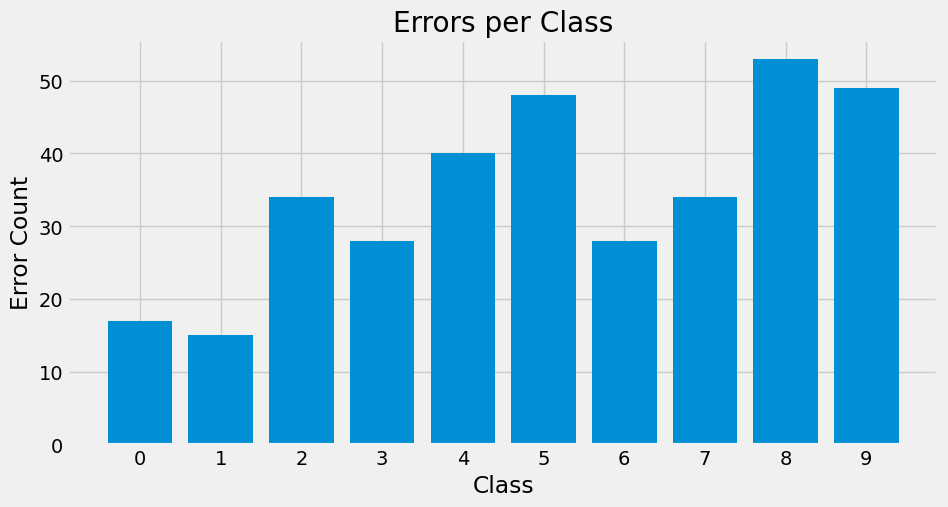

In [7]:
plt.figure(figsize=(10, 5))
errors = (pred_labels != test_labels)
error_counts = np.bincount(test_labels[errors])
plt.bar(range(10), error_counts, tick_label=range(10))
plt.xlabel("Class")
plt.ylabel("Error Count")
plt.title("Errors per Class")
plt.show()